<h3> Setup </h3>

In [1]:
'''Pretraining
- using the real validation set'''

import logging
import logging.config

import configparser as cp
import args

import numpy as np
from keras.preprocessing.sequence import pad_sequences
import pickle

import vectorizer
import load
import sample

#configurations
config = cp.ConfigParser(strict=False)
config.read('defaults.cfg')

#argparser
args = args.get_args()
'''
>>> args.train
False
'''

#logging
logger = logging.getLogger(__name__)
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s [%(levelname)s] %(name)s: %(message)s'
        },
    },
    'handlers': {
        'default': {
            'level':'INFO',
            'formatter': 'standard',
            'class':'logging.StreamHandler',
        },
    },
    'loggers': {
        '': {
            'handlers': ['default'],
            'level': 'INFO',
            'propagate': True
        }
    }
})

Using TensorFlow backend.
usage: ipykernel_launcher.py [-h] [-t]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1016/jupyter/kernel-1e7168de-ca14-41d6-8adf-037c64c90c2b.json


SystemExit: 2

/home/lhchan/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# word embedding
vector_model, vocabulary, inversed_vocabulary = vectorizer.prepare_embedding_vocab('/home/lhchan/disease_normalization/data/pubmed2018_w2v_400D/pubmed2018_w2v_400D.bin', binary = True, limit = 1000000)
# vector_model, vocabulary, inversed_vocabulary = vectorizer.prepare_embedding_vocab('/home/lenz/disease-normalization/data/embeddings/wvec_50_haodi-li-et-al.bin', binary = True, limit = 1000000)
pretrained = vectorizer.load_pretrained_word_embeddings(vocabulary, vector_model)

# MEDIC dictionary
dictionary = load.Terminology()
# dictionary of entries, key = canonical id, value = named tuple in the form of
#   MEDIC_ENTRY(DiseaseID='MESH:D005671', DiseaseName='Fused Teeth',
#   AllDiseaseIDs=('MESH:D005671',), AllNames=('Fused Teeth', 'Teeth, Fused')
dictionary.loaded = load.load(config['terminology']['dict_file'],'MEDIC')


def concept_obj(conf,dictionary,order=None):
    # concept_ids = [] # list of all concept ids
    # concept_all_ids = [] # list of (lists of all concept ids with alt IDs)
    concept_names = [] # list of all names, same length as concept_ids
    # concept_map = {} # names as keys, ids as concepts

    if order:
        use = order
        logger.info('Re-initialing concept object.')
    else:
        use = dictionary.loaded.keys()

    for k in use:
    # keys not in congruent order! To make them congruent:
    # k,v = zip(*dictionary.loaded.items())
    # k = list(k)
    # k.sort()
        # c_id = dictionary.loaded[k].DiseaseID
        # a_ids = dictionary.loaded[k].AllDiseaseIDs
        for n in dictionary.loaded[k].AllNames:
            concept_names.append(n)

    # tokenization & vectorization of dictionary terms
    import nltk
    concept_tokenize = [nltk.word_tokenize(name) for name in concept_names] # list of list of tokenized names
    concept_vectorize = np.array([[vocabulary.get(text.lower(),1) for text in concept] for concept in concept_tokenize])


    # save the stuff to object
    concept = sample.NewDataSet('concepts')
    #concept.ids = concept_ids
    #concept.all_ids = concept_all_ids
    concept.names = concept_names
    #concept.map = concept_map
    concept.tokenize = concept_tokenize
    concept.vectorize = concept_vectorize
    for corpus in [concept]:
        logger.info('Padding {0}'.format(corpus.info))
        logger.info('Old shape: {0}'.format(corpus.vectorize.shape))
        corpus.padded = pad_sequences(corpus.vectorize, padding='post', maxlen=int(config['embedding']['length']))
        #format of corpus.padded: numpy, mentions, padded
        logger.info('New shape: {0}'.format(corpus.padded.shape))

    return concept


# get the real validation data
[real_tr_data,real_val_data,concept_order] = pickle.load(open('gitig_new_data.pickle','rb'))
real_tr_data.y=np.array(real_tr_data.y)
real_val_data.y=np.array(real_val_data.y)
# reload the concept dict so that it is in the order when the data for predicion is created
concept = concept_obj(config,dictionary,order=concept_order)


# corpus
corpus_train = sample.NewDataSet('training corpus')
corpus_train.objects = load.load(config['corpus']['training_file'],'NCBI')

corpus_dev = sample.NewDataSet('dev corpus')
corpus_dev.objects = load.load(config['corpus']['development_file'],'NCBI')

for corpus in [corpus_train, corpus_dev]:
    # mention_ids = [] # list of all ids (gold standard for each mention)
    mention_names = [] # list of all names
    # mention_all = [] # list of tuples (mention_text,gold,context,(start,end,docid))

    #sth wrong here that sometimes throw an error
    #import pdb;pdb.set_trace()
    for abstract in corpus.objects:
        for section in abstract.sections: # title and abstract
            for mention in section.mentions:
                # nor_ids = [sample._nor_id(one_id) for one_id in mention.id]
                # mention_ids.append(nor_ids) # append list of ids, usually len(list)=1
                mention_names.append(mention.text)
                # mention_all.append((mention.text,nor_ids,section.text,(mention.start,mention.end,abstract.docid)))

    # tokenization & vectorization of mentions
    import nltk
    mention_tokenize = [nltk.word_tokenize(name) for name in mention_names]
    mention_vectorize = np.array([[vocabulary.get(text.lower(),1) for text in mention] for mention in mention_tokenize])

    # corpus.ids = mention_ids
    corpus.names = mention_names
    # corpus.all = mention_all
    corpus.tokenize = mention_tokenize
    corpus.vectorize = mention_vectorize

for corpus in [corpus_train,corpus_dev]:
    logger.info('Padding {0}'.format(corpus.info))
    logger.info('Old shape: {0}'.format(corpus.vectorize.shape))
    corpus.padded = pad_sequences(corpus.vectorize, padding='post', maxlen=int(config['embedding']['length']))
    #format of corpus.padded: numpy, mentions, padded
    logger.info('New shape: {0}'.format(corpus.padded.shape))

<h3> Data for pretraining </h3>

In [ ]:
collection_names = concept.names + corpus_train.names
collection_tokenize = concept.tokenize + corpus_train.tokenize
collection = np.concatenate((concept.padded, corpus_train.padded),axis=0)
# split the training and validation set
# cutoff = len(collection) - len(collection)//10


# questions, answers, labels
questions = [term for term in collection for i in range(2)]
answers = []
labels = []
mentions = []

import random

for i, c in enumerate(collection):
    order = random.randint(0,1)
    j = i-1000
    try:
        # test that the vectorized 'random' sample is not the same as the question
        identical = c==collection[j]
        assert not identical.all()
    except AssertionError:
        identical = c==collection[j]
        while identical.all():
            j = j -10
            identical = c==collection[j]
    if order:
        answers.append(c)
        answers.append(collection[j])
        labels.extend([1,0])
    else:
        answers.append(collection[j])
        answers.append(c)
        labels.extend([0,1])


# using all synthetic data for training, real development data for validation
tr_data = sample.Data()
tr_data.x = [np.array(questions),np.array(answers)]
tr_data.y = np.array(labels)
tr_data.mentions=[]
for i, c in enumerate(collection):
    tr_data.mentions.append((i*2,i*2+2,collection_names[i]))


'''
tr_data = sample.Data()
val_data = sample.Data()
tr_data.x = [np.array(questions[:cutoff*2]),np.array(answers[:cutoff*2])]
val_data.x = [np.array(questions[cutoff*2:]),np.array(answers[cutoff*2:])]
tr_data.y = np.array(labels[:cutoff*2])
val_data.y = np.array(labels[cutoff*2:])
tr_data.mentions=[]
val_data.mentions=[]
for i, c in enumerate(collection[:cutoff]):
    tr_data.mentions.append((i*2,i*2+2,collection_names[i]))
for i, c in enumerate(collection[cutoff:]):
    val_data.mentions.append((i*2,i*2+2,collection_names[i]))
# assert len(val_data.mentions)==len(val_data.y)/2
'''

<h3> CNN</h3>

In [ ]:
# cnn, filter = 70
import cnn, model_tools
cnn.print_input(tr_data)
from callback import EarlyStoppingRankingAccuracySpedUp, EarlyStoppingRankingAccuracySpedUpSharedEncoder

In [ ]:
# pretraining with shared encoders
evaluation_function_shared = EarlyStoppingRankingAccuracySpedUpSharedEncoder(config,real_val_data,concept.padded,corpus_dev.padded,pretrained)
model_shared_encoder = cnn.build_model_shared_encoder(config,tr_data,vocabulary,pretrained)
model_shared_encoder.summary()
hist_shared = model_shared_encoder.fit(tr_data.x, tr_data.y, epochs=15, batch_size=100,callbacks=[evaluation_function_shared])

<pre>
Epoch 1/15
145854/145854 [==============================] - 23s 155us/step - loss: 0.1212
2019-03-21 17:01:10,835 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 17:19:40,200 [INFO] callback: Time taken for prediction with speedup:0:18:53.542682
2019-03-21 17:20:20,506 [WARNING] callback: High chance of same prediction scores.
2019-03-21 17:20:24,591 [INFO] callback: Accuracy: 0.2668360864040661, Correct: 210, Total: 787
2019-03-21 17:20:39,368 [INFO] callback: Testing: epoch: 0, self.model.stop_training: False
Epoch 2/15
145854/145854 [==============================] - 22s 153us/step - loss: 0.0163
2019-03-21 17:21:24,657 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 17:39:16,153 [INFO] callback: Time taken for prediction with speedup:0:18:14.443193
2019-03-21 17:39:55,910 [WARNING] callback: High chance of same prediction scores.
2019-03-21 17:40:00,278 [INFO] callback: Accuracy: 0.18170266836086404, Correct: 143, Total: 787
2019-03-21 17:40:03,532 [INFO] callback: Testing: epoch: 1, self.model.stop_training: False
Epoch 3/15
145854/145854 [==============================] - 22s 151us/step - loss: 0.0096
2019-03-21 17:40:49,985 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 18:00:35,422 [INFO] callback: Time taken for prediction with speedup:0:20:09.888632
2019-03-21 18:01:16,087 [WARNING] callback: High chance of same prediction scores.
2019-03-21 18:01:20,340 [INFO] callback: Accuracy: 0.2071156289707751, Correct: 163, Total: 787
2019-03-21 18:01:24,280 [INFO] callback: Testing: epoch: 2, self.model.stop_training: False
Epoch 4/15
145854/145854 [==============================] - 22s 150us/step - loss: 0.0062
2019-03-21 18:02:09,663 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 18:20:40,314 [INFO] callback: Time taken for prediction with speedup:0:18:54.191646
2019-03-21 18:21:22,492 [WARNING] callback: High chance of same prediction scores.
2019-03-21 18:21:26,911 [INFO] callback: Accuracy: 0.21982210927573062, Correct: 173, Total: 787
2019-03-21 18:21:29,987 [INFO] callback: Testing: epoch: 3, self.model.stop_training: False
Epoch 5/15
145854/145854 [==============================] - 22s 148us/step - loss: 0.0058
2019-03-21 18:22:12,353 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 18:40:04,521 [INFO] callback: Time taken for prediction with speedup:0:18:12.973241
2019-03-21 18:40:45,150 [WARNING] callback: High chance of same prediction scores.
2019-03-21 18:40:49,399 [INFO] callback: Accuracy: 0.2795425667090216, Correct: 220, Total: 787
2019-03-21 18:41:06,514 [INFO] callback: Testing: epoch: 4, self.model.stop_training: False
Epoch 6/15
145854/145854 [==============================] - 22s 148us/step - loss: 0.0038
2019-03-21 18:41:50,945 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 19:00:05,383 [INFO] callback: Time taken for prediction with speedup:0:18:37.234304
2019-03-21 19:00:46,393 [WARNING] callback: High chance of same prediction scores.
2019-03-21 19:00:50,861 [INFO] callback: Accuracy: 0.25667090216010163, Correct: 202, Total: 787
2019-03-21 19:00:53,757 [INFO] callback: Testing: epoch: 5, self.model.stop_training: False
Epoch 7/15
145854/145854 [==============================] - 22s 148us/step - loss: 0.0036
2019-03-21 19:01:38,273 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 19:19:55,314 [INFO] callback: Time taken for prediction with speedup:0:18:39.973469
2019-03-21 19:20:42,788 [WARNING] callback: High chance of same prediction scores.
2019-03-21 19:20:47,738 [INFO] callback: Accuracy: 0.17916137229987295, Correct: 141, Total: 787
2019-03-21 19:20:51,320 [INFO] callback: Testing: epoch: 6, self.model.stop_training: False
Epoch 8/15
145854/145854 [==============================] - 22s 150us/step - loss: 0.0030
2019-03-21 19:21:34,819 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 19:39:49,047 [INFO] callback: Time taken for prediction with speedup:0:18:35.882419
2019-03-21 19:40:29,781 [WARNING] callback: High chance of same prediction scores.
2019-03-21 19:40:34,072 [INFO] callback: Accuracy: 0.17662007623888182, Correct: 139, Total: 787
2019-03-21 19:40:37,318 [INFO] callback: Testing: epoch: 7, self.model.stop_training: False
Epoch 9/15
145854/145854 [==============================] - 22s 153us/step - loss: 0.0022
2019-03-21 19:41:18,483 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 19:59:41,108 [INFO] callback: Time taken for prediction with speedup:0:18:41.519463
2019-03-21 20:00:22,068 [WARNING] callback: High chance of same prediction scores.
2019-03-21 20:00:26,283 [INFO] callback: Accuracy: 0.09783989834815757, Correct: 77, Total: 787
2019-03-21 20:00:29,491 [INFO] callback: Testing: epoch: 8, self.model.stop_training: False
Epoch 10/15
145854/145854 [==============================] - 22s 153us/step - loss: 0.0016
2019-03-21 20:01:13,610 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 20:20:37,810 [INFO] callback: Time taken for prediction with speedup:0:19:46.066551
2019-03-21 20:21:20,325 [WARNING] callback: High chance of same prediction scores.
2019-03-21 20:21:24,914 [INFO] callback: Accuracy: 0.22617534942820838, Correct: 178, Total: 787
2019-03-21 20:21:28,452 [INFO] callback: Testing: epoch: 9, self.model.stop_training: False
Epoch 11/15
145854/145854 [==============================] - 22s 148us/step - loss: 0.0017
2019-03-21 20:22:13,532 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 20:42:32,072 [INFO] callback: Time taken for prediction with speedup:0:20:42.094759
2019-03-21 20:43:12,273 [WARNING] callback: High chance of same prediction scores.
2019-03-21 20:43:16,662 [INFO] callback: Accuracy: 0.16518424396442186, Correct: 130, Total: 787
2019-03-21 20:43:19,602 [INFO] callback: Testing: epoch: 10, self.model.stop_training: False
Epoch 12/15
145854/145854 [==============================] - 21s 144us/step - loss: 0.0022
2019-03-21 20:44:03,143 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 21:04:27,763 [INFO] callback: Time taken for prediction with speedup:0:20:47.193820
2019-03-21 21:05:09,456 [WARNING] callback: High chance of same prediction scores.
2019-03-21 21:05:13,883 [INFO] callback: Accuracy: 0.08386277001270648, Correct: 66, Total: 787
2019-03-21 21:05:17,473 [INFO] callback: Testing: epoch: 11, self.model.stop_training: False
Epoch 13/15
145854/145854 [==============================] - 21s 144us/step - loss: 0.0011
2019-03-21 21:06:02,502 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 21:26:47,759 [INFO] callback: Time taken for prediction with speedup:0:21:09.325388
2019-03-21 21:27:28,688 [WARNING] callback: High chance of same prediction scores.
2019-03-21 21:27:33,078 [INFO] callback: Accuracy: 0.22998729351969505, Correct: 181, Total: 787
2019-03-21 21:27:36,592 [INFO] callback: Testing: epoch: 12, self.model.stop_training: False
Epoch 14/15
145854/145854 [==============================] - 21s 143us/step - loss: 0.0010
2019-03-21 21:28:19,696 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 21:48:22,850 [INFO] callback: Time taken for prediction with speedup:0:20:25.436513
2019-03-21 21:49:04,166 [WARNING] callback: High chance of same prediction scores.
2019-03-21 21:49:08,602 [INFO] callback: Accuracy: 0.22617534942820838, Correct: 178, Total: 787
2019-03-21 21:49:12,323 [INFO] callback: Testing: epoch: 13, self.model.stop_training: False
Epoch 15/15
145854/145854 [==============================] - 21s 143us/step - loss: 8.4565e-04
2019-03-21 21:49:56,265 [INFO] cnn: Formatting pooled mentions and candidates...
2019-03-21 22:11:01,436 [INFO] callback: Time taken for prediction with speedup:0:21:28.288053
2019-03-21 22:11:42,059 [WARNING] callback: High chance of same prediction scores.
2019-03-21 22:11:46,280 [INFO] callback: Accuracy: 0.1181702668360864, Correct: 93, Total: 787
2019-03-21 22:11:50,169 [INFO] callback: Testing: epoch: 14, self.model.stop_training: False
2019-03-21 22:12:01,872 [INFO] model_tools: Model saved.
</pre>

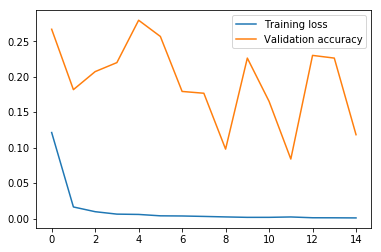

In [2]:
# shared encoder, filter = 70, batch size = 100, optimizer = adadelta (default parameters)
# trained on clean synthetic data, validation on development set using all candidates

# hist_shared.history['loss']
training_loss_shared = [0.12122173667886577,
 0.01629756788750736,
 0.009621379802336228,
 0.006190596503196425,
 0.005754312871903281,
 0.0037930744669940077,
 0.003569770248513475,
 0.0029529786084423154,
 0.0022472188662374677,
 0.00163682504720262,
 0.001653142040828476,
 0.0021921120665948134,
 0.0010779243026547251,
 0.0010091451778674275,
 0.0008456482517533081]

# evaluation_function_shared.accuracy
real_val_data_accuracy = [0.2668360864040661,
 0.18170266836086404,
 0.2071156289707751,
 0.21982210927573062,
 0.2795425667090216,
 0.25667090216010163,
 0.17916137229987295,
 0.17662007623888182,
 0.09783989834815757,
 0.22617534942820838,
 0.16518424396442186,
 0.08386277001270648,
 0.22998729351969505,
 0.22617534942820838,
 0.1181702668360864]


%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [training_loss_shared, real_val_data_accuracy]
labels = ['Training loss','Validation accuracy']
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function,label=labels[i])
plt.legend()
plt.show()

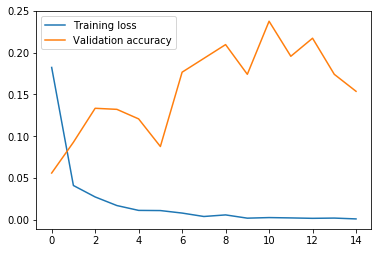

In [1]:
# separate encoder, filter = 70, batch size = 100, optimizer = adadelta (default parameters)
# trained on clean synthetic data, validation on development set using all candidates

# hist_shared.history['loss']
training_loss_shared = [0.1823,0.0410,0.0273,0.0170,0.0112,0.0110,
                       0.0080,0.0039,0.0058,0.0019,0.0026,0.0022,
                        0.0017,0.0020,0.0010]

# evaluation_function_shared.accuracy
real_val_data_accuracy = [0.05590851334180432,0.09275730622617535,
                          0.13341804320203304,0.13214739517153748,
                          0.1207115628970775,0.08767471410419314,
                          0.17662007623888182,0.193138500635324,
                          0.2096569250317662,0.17407878017789072,
                          0.23761118170266837,0.19567979669631513,
                          0.21728081321473952,0.17407878017789072,
                          0.15374841168996187
                         ]


%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [training_loss_shared, real_val_data_accuracy]
labels = ['Training loss','Validation accuracy']
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function,label=labels[i])
plt.legend()
plt.show()

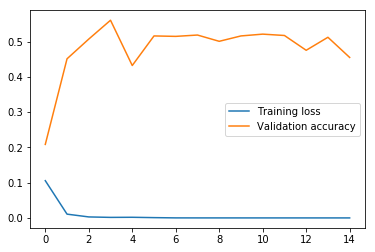

In [2]:
# shared encoder, filter = 70, batch size = 100, optimizer = adam (default parameters)
# trained on clean synthetic data, validation on development set using all candidates

# hist_shared.history['loss']
training_loss_shared = [0.1056,0.0107,0.0028,0.0015,0.0018,8.2689e-04,
                       8.1696e-05,3.0494e-05,1.5024e-05,7.6510e-06,
                       3.6991e-06,1.6286e-06,7.8924e-07,4.2610e-07,
                       2.3797e-07]

# evaluation_function_shared.accuracy
real_val_data_accuracy = [0.20838627700127066,0.45108005082592123,
                         0.5069885641677255,0.5603557814485387,
                         0.4320203303684879,0.5158831003811944,
                         0.5146124523506989,0.5184243964421855,
                         0.5006353240152478,0.5158831003811944,
                         0.5209656925031766,0.5171537484116899,
                         0.47522236340533675,0.5120711562897078,
                         0.4548919949174079]


%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [training_loss_shared, real_val_data_accuracy]
labels = ['Training loss','Validation accuracy']
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function,label=labels[i])
plt.legend()
plt.show()

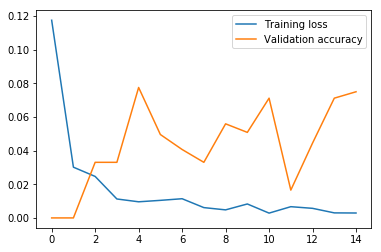

In [1]:
# separate encoder, filter = 70, batch size = 100, optimizer = adam (default parameters)
# trained on clean synthetic data, validation on development set using all candidates

# hist_shared.history['loss']
training_loss_shared = [0.11746009620646755, 0.03014811401492183, 
                        0.02465001542302144, 0.011253485151599341, 
                        0.009579271258045299, 0.010435030651704582, 
                        0.011403390003353693, 0.00612910134475073, 
                        0.004780362331869767, 0.008287435955259439, 
                        0.00285560191318566, 0.006675794551786384, 
                        0.005692208197895868, 0.0029921359760846354, 
                        0.0029190899139712855]

# evaluation_function_shared.accuracy
real_val_data_accuracy = [0.0, 0.0, 0.03303684879288437, 0.03303684879288437, 
                          0.07750952986022872, 0.04955527318932656, 
                          0.04066073697585769, 0.03303684879288437, 
                          0.05590851334180432, 0.05082592121982211, 
                          0.07115628970775095, 0.016518424396442185, 
                          0.044472681067344345, 0.07115628970775095, 
                          0.07496823379923762]


%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [training_loss_shared, real_val_data_accuracy]
labels = ['Training loss','Validation accuracy']
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function,label=labels[i])
plt.legend()
plt.show()

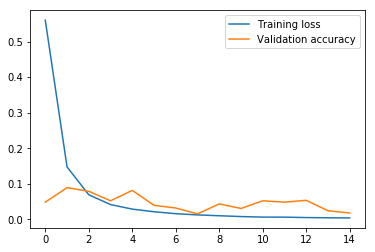

In [2]:
# shared encoder, no dense layer, filter = 70, batch size = 100, optimizer = adadelta (default parameters)
# trained on clean synthetic data, validation on development set using all candidates

# hist_shared.history['loss']
training_loss_shared = [0.5599806619442097, 0.14749055139820869, 
                        0.0689691181324133, 0.04151881927739944, 
                        0.028646802216900403, 0.02128240861661451, 
                        0.015813236499647842, 0.012374845554982907, 
                        0.01004381102062772, 0.007743480581530568, 
                        0.006167155078219671, 0.006072788558258934, 
                        0.004888206938259381, 0.004281970077815528, 
                        0.003901777767864554]

# evaluation_function_shared.accuracy
real_val_data_accuracy = [0.048284625158831, 0.08894536213468869, 
                          0.07878017789072427, 0.052096569250317665, 
                          0.08132147395171538, 0.03939008894536213, 
                          0.03176620076238882, 0.015247776365946633, 
                          0.043202033036848796, 0.030495552731893267, 
                          0.052096569250317665, 0.048284625158831, 
                          0.053367217280813214, 0.0241423125794155, 
                          0.017789072426937738]


%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [training_loss_shared, real_val_data_accuracy]
labels = ['Training loss','Validation accuracy']
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function,label=labels[i])
plt.legend()
plt.show()

In [ ]:
# pretraining with separate encoders
evaluation_function_separate = EarlyStoppingRankingAccuracySpedUp(config,real_val_data,concept.padded,corpus_dev.padded,pretrained)
model_separate_encoder = cnn.build_model(config,tr_data,vocabulary,pretrained)
model_separate_encoder.summary()
hist_separate = model_separate_encoder.fit(tr_data.x, tr_data.y, epochs=15, batch_size=100,callbacks=[evaluation_function_separate])

In [ ]:
# Plot the f-scores for each activation function

%matplotlib inline
import matplotlib.pyplot as plt
evaluation_functions = [evaluation_function_shared, evaluation_function_separate]
#plt.ylim(0.4,0.6)
for i,evaluation_function in enumerate(evaluation_functions):
    plt.plot(evaluation_function.accuracy,label=hidden_activations[i])
plt.legend()
plt.show()

In [ ]:
# Note
# list all data in history
print(history.history.keys())